<a href="https://colab.research.google.com/github/abracadabrabrabra/ml_labs-homework/blob/main/ml_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv("/content/drive/MyDrive/ml_lab1/unzipped/train.csv")
test = pd.read_csv("/content/drive/MyDrive/ml_lab1/unzipped/test.csv")

In [40]:
train = train.dropna(subset=["RiskScore"])

train = train[
    (train["RiskScore"] > 0) &
    (train["RiskScore"] <= 100)
]

threshold = train["RiskScore"].quantile(0.65)
train["LoanApproved"] = (train["RiskScore"] >= threshold).astype(int)

train = train.drop(columns=["RiskScore"])

In [41]:
loan_dist = train["LoanApproved"].value_counts(normalize=True)
loan_dist

,proportion
LoanApproved,
0,0.650019
1,0.349981


#EDA

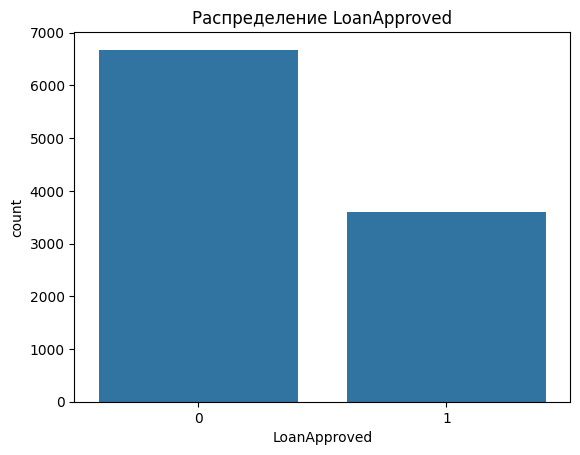

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="LoanApproved", data=train)
plt.title("Распределение LoanApproved")
plt.show()

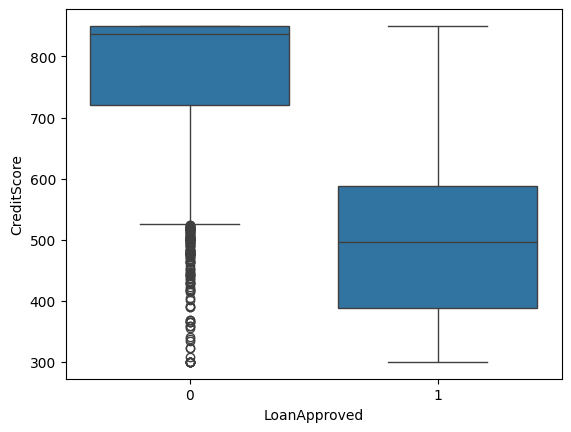

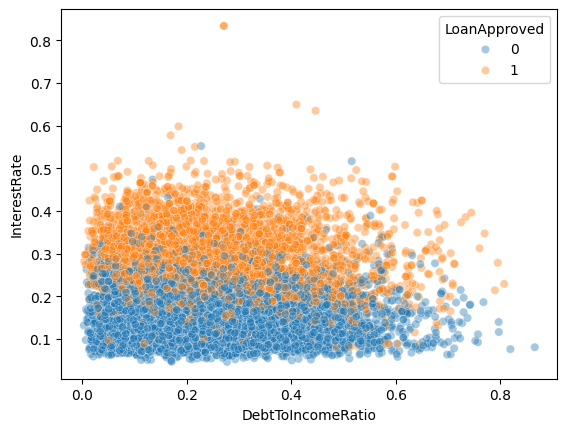

In [43]:
sns.boxplot(x="LoanApproved", y="CreditScore", data=train)
plt.show()

sns.scatterplot(
    x="DebtToIncomeRatio",
    y="InterestRate",
    hue="LoanApproved",
    data=train,
    alpha=0.4
)
plt.show()

In [44]:
from sklearn import set_config
set_config(transform_output="pandas")

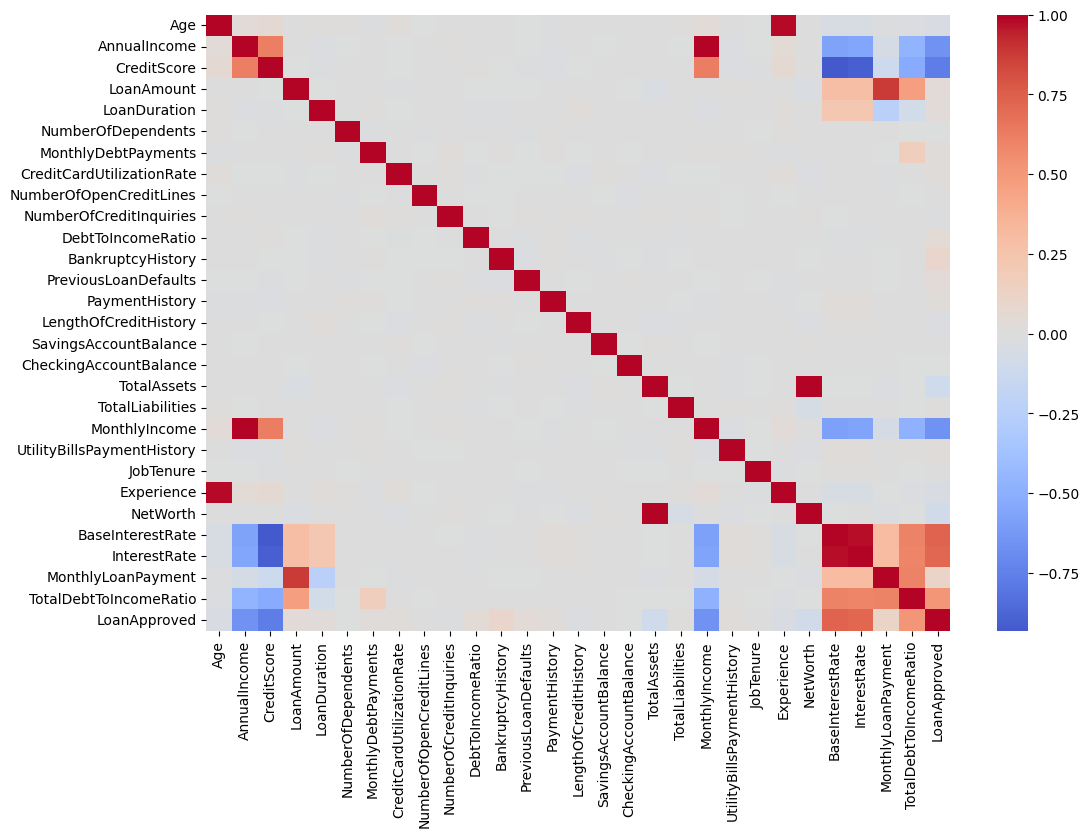

In [63]:
plt.figure(figsize=(12,8))
sns.heatmap(
    train.select_dtypes(include=np.number).corr(),
    cmap="coolwarm",
    center=0
)
plt.show()

#Выводы

#1)Boxplot: CreditScore vs LoanApproved
CreditScore — сильный предиктор.

Для LoanApproved = 0:
медиана CreditScore высокая (примерно 820–840),
узкое распределение.

Для LoanApproved = 1:
медиана заметно ниже (примерно 480–500),
большой разброс значений.

Интерпретация: чем выше кредитный рейтинг, тем ниже вероятность отклонения кредита (LoanApproved=1 означает отказ, это видно в коде submit).


#2)Scatter plot: InterestRate vs DebtToIncomeRatio
Класс LoanApproved = 1 (оранжевый): выше процентные ставки, выше долговая нагрузка.

Класс LoanApproved = 0 (синий): сконцентрирован в области низких ставок и низкого DTI.

Интерпретация: заёмщики с высокой долговой нагрузкой и высокой процентной ставкой чаще не получают кредит.


#3)Корреляционная матрица
#Самые сильные корреляции с LoanApproved
#Отрицательные:

CreditScore

AnnualIncome

MonthlyIncome

NetWorth

#Интерпретация: чем лучше финансовое положение, тем меньше вероятность LoanApproved=1

#Положительные:

InterestRate

TotalDebtToIncomeRatio

MonthlyLoanPayment

#Интерпретация: чем выше риск и нагрузка, тем выше вероятность LoanApproved=1

#Мультиколлинеарность (сильные корреляции):

AnnualIncome <-> MonthlyIncome

LoanAmount <-> MonthlyLoanPayment

InterestRate <-> BaseInterestRate


#Preprocessing

In [45]:
X = train.drop(columns=["LoanApproved"])
y = train["LoanApproved"]
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)



In [48]:
from sklearn.linear_model import LogisticRegression

base_model = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        max_iter=3000,
        solver="lbfgs"
    ))
])

#Bagging

In [49]:
from sklearn.base import clone
import numpy as np

class CustomBaggingClassifier:
    def __init__(self, base_model, n_estimators=10, random_state=42):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        self.models = []
        rng = np.random.RandomState(self.random_state)

        n_samples = len(X)

        for _ in range(self.n_estimators):
            idx = rng.choice(n_samples, n_samples, replace=True)
            X_sample = X.iloc[idx]
            y_sample = y.iloc[idx]

            model = clone(self.base_model)
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict_proba(self, X):
        probs = [m.predict_proba(X) for m in self.models]
        return np.mean(probs, axis=0)

In [57]:
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)

In [59]:
from sklearn.linear_model import LogisticRegression

base_model = LogisticRegression(
    max_iter=3000,
    solver="lbfgs"
)

In [60]:
custom_bag = CustomBaggingClassifier(
    base_model=base_model,
    n_estimators=10
)

custom_bag.fit(X_train_prep, y_train)
custom_preds = custom_bag.predict_proba(X_val_prep)[:, 1]

In [61]:
from sklearn.ensemble import BaggingClassifier

sk_bag = BaggingClassifier(
    estimator=base_model,
    n_estimators=10,
    random_state=42,
    n_jobs=1
)

sk_bag.fit(X_train_prep, y_train)
sk_preds = sk_bag.predict_proba(X_val_prep)[:, 1]

In [62]:
from sklearn.metrics import roc_auc_score

print("Custom Bagging ROC-AUC:", roc_auc_score(y_val, custom_preds))
print("Sklearn Bagging ROC-AUC:", roc_auc_score(y_val, sk_preds))

Custom Bagging ROC-AUC: 0.9898280629283853
Sklearn Bagging ROC-AUC: 0.9898457604956984


#Boosting

In [64]:
import numpy as np
from sklearn.base import clone
from scipy.special import expit


class CustomGradientBoostingClassifier:
    def __init__(self, base_model, n_estimators=50, learning_rate=0.1):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        self.init_pred = None

    def fit(self, X, y):
        p = np.clip(y.mean(), 1e-6, 1 - 1e-6)
        self.init_pred = np.log(p / (1 - p))
        y_pred = np.full(len(y), self.init_pred)

        for _ in range(self.n_estimators):
            residuals = y - expit(y_pred)
            model = clone(self.base_model)
            model.fit(X, residuals)
            self.models.append(model)
            y_pred += self.learning_rate * model.predict(X)

        return self

    def predict_proba(self, X):
        y_pred = np.full(X.shape[0], self.init_pred)
        for model in self.models:
            y_pred += self.learning_rate * model.predict(X)

        probs = expit(y_pred)
        return np.column_stack([1 - probs, probs])

In [65]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [66]:
base_tree = DecisionTreeRegressor(max_depth=3)

custom_gb = CustomGradientBoostingClassifier(
    base_model=base_tree,
    n_estimators=50,
    learning_rate=0.1
)

custom_gb.fit(X_train_prep, y_train)
custom_preds = custom_gb.predict_proba(X_val_prep)[:, 1]

sk_gb = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

sk_gb.fit(X_train_prep, y_train)
sk_preds = sk_gb.predict_proba(X_val_prep)[:, 1]

print("Custom GB ROC-AUC:", roc_auc_score(y_val, custom_preds))
print("Sklearn GB ROC-AUC:", roc_auc_score(y_val, sk_preds))

Custom GB ROC-AUC: 0.9817309053659025
Sklearn GB ROC-AUC: 0.9899920256843753


#Comparsion Gradient Boosting Models

In [68]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.2 MB/s eta 0:00:00


In [69]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

models = {
    "Sklearn GB": GradientBoostingClassifier(random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        eval_metric="logloss",
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=300,
        verbose=0,
        random_state=42
    )
}

results = {}

for name, model in models.items():
    model.fit(X_train_prep, y_train)
    preds = model.predict_proba(X_val_prep)[:, 1]
    results[name] = roc_auc_score(y_val, preds)

results

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2876, number of negative: 5341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4603
[LightGBM] [Info] Number of data points in the train set: 8217, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.350006 -> initscore=-0.619012
[LightGBM] [Info] Start training from score -0.619012


{'Sklearn GB': np.float64(0.9905573068050271),
 'LightGBM': np.float64(0.9928699624395161),
 'XGBoost': np.float64(0.9925160110932517),
 'CatBoost': np.float64(0.991771672232725)}

#Optuna

In [70]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.9 MB/s eta 0:00:00


In [72]:
import optuna


def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state": 42,
        "n_jobs": -1
    }

    model = LGBMClassifier(**params)
    model.fit(X_train_prep, y_train)

    preds = model.predict_proba(X_val_prep)[:, 1]
    return roc_auc_score(y_val, preds)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
study.best_params

[I 2025-12-14 14:48:13,669] A new study created in memory with name: no-name-22c83ee9-8a54-438e-a7d8-a6f234b298b0


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:48:29,136] Trial 0 finished with value: 0.9921131311785332 and parameters: {'n_estimators': 383, 'learning_rate': 0.11632296007552596, 'max_depth': 8, 'num_leaves': 125, 'min_child_samples': 36, 'subsample': 0.99950306968826, 'colsample_bytree': 0.7073954215644325}. Best is trial 0 with value: 0.9921131311785332.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2025-12-14 14:48:32,466] Trial 1 finished with value: 0.9930188302116212 and parameters: {'n_estimators': 356, 'learning_rate': 0.07731322750400568, 'max_depth': 10, 'num_leaves': 44, 'min_child_samples': 11, 'subsample': 0.7638712427206781, 'colsample_bytree': 0.6024332310923741}. Best is trial 1 with value: 0.9930188302116212.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:48:35,751] Trial 2 finished with value: 0.9924608363245693 and parameters: {'n_estimators': 727, 'learning_rate': 0.12223949542123112, 'max_depth': 4, 'num_leaves': 56, 'min_child_samples': 91, 'subsample': 0.9716387956799152, 'colsample_bytree': 0.9743936437104633}. Best is trial 1 with value: 0.9930188302116212.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:48:45,499] Trial 3 finished with value: 0.9924847800921106 and parameters: {'n_estimators': 592, 'learning_rate': 0.11188121823992336, 'max_depth': 6, 'num_leaves': 94, 'min_child_samples': 88, 'subsample': 0.9270270530880743, 'colsample_bytree': 0.6783455347115432}. Best is trial 1 with value: 0.9930188302116212.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:48:50,162] Trial 4 finished with value: 0.9920714898436785 and parameters: {'n_estimators': 780, 'learning_rate': 0.08114978740650784, 'max_depth': 6, 'num_leaves': 60, 'min_child_samples': 14, 'subsample': 0.8839116546334196, 'colsample_bytree': 0.6992986276667356}. Best is trial 1 with value: 0.9930188302116212.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:48:54,079] Trial 5 finished with value: 0.9923848408884596 and parameters: {'n_estimators': 533, 'learning_rate': 0.1901628930728263, 'max_depth': 7, 'num_leaves': 45, 'min_child_samples': 65, 'subsample': 0.732439917099756, 'colsample_bytree': 0.9360734418896531}. Best is trial 1 with value: 0.9930188302116212.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:49:00,217] Trial 6 finished with value: 0.9921568545801305 and parameters: {'n_estimators': 630, 'learning_rate': 0.15505605905104175, 'max_depth': 6, 'num_leaves': 101, 'min_child_samples': 21, 'subsample': 0.9398462128770724, 'colsample_bytree': 0.7365335212225547}. Best is trial 1 with value: 0.9930188302116212.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-14 14:49:03,461] Trial 7 finished with value: 0.9926846584994129 and parameters: {'n_estimators': 265, 'learning_rate': 0.15902009557049904, 'max_depth': 9, 'num_leaves': 42, 'min_child_samples': 22, 'subsample': 0.788865703212129, 'colsample_bytree': 0.8522905665286092}. Best is trial 1 with value: 0.9930188302116212.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:49:07,188] Trial 8 finished with value: 0.9924473028907416 and parameters: {'n_estimators': 667, 'learning_rate': 0.13937209729882866, 'max_depth': 6, 'num_leaves': 63, 'min_child_samples': 99, 'subsample': 0.7023355685982035, 'colsample_bytree': 0.7616378258356536}. Best is trial 1 with value: 0.9930188302116212.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:49:14,814] Trial 9 finished with value: 0.992497272492567 and parameters: {'n_estimators': 784, 'learning_rate': 0.15048463006671217, 'max_depth': 9, 'num_leaves': 44, 'min_child_samples': 88, 'subsample': 0.7325646386736213, 'colsample_bytree': 0.6462308226397111}. Best is trial 1 with value: 0.9930188302116212.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2025-12-14 14:49:17,709] Trial 10 finished with value: 0.9931697800504693 and parameters: {'n_estimators': 399, 'learning_rate': 0.03820874762531329, 'max_depth': 10, 'num_leaves': 16, 'min_child_samples': 48, 'subsample': 0.6357424036235798, 'colsample_bytree': 0.6198508666267979}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2025-12-14 14:49:20,748] Trial 11 finished with value: 0.9930802511805318 and parameters: {'n_estimators': 401, 'learning_rate': 0.023880756131919933, 'max_depth': 10, 'num_leaves': 21, 'min_child_samples': 52, 'subsample': 0.6150353961989824, 'colsample_bytree': 0.6022361306571724}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2025-12-14 14:49:24,119] Trial 12 finished with value: 0.9929771888767667 and parameters: {'n_estimators': 435, 'learning_rate': 0.02206254859214593, 'max_depth': 10, 'num_leaves': 16, 'min_child_samples': 52, 'subsample': 0.6013682886999425, 'colsample_bytree': 0.6007582026494839}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:49:28,201] Trial 13 finished with value: 0.9916654868288458 and parameters: {'n_estimators': 213, 'learning_rate': 0.02817380243823467, 'max_depth': 4, 'num_leaves': 16, 'min_child_samples': 59, 'subsample': 0.6205740880130642, 'colsample_bytree': 0.8596144532239588}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2025-12-14 14:49:31,548] Trial 14 finished with value: 0.9928491417720887 and parameters: {'n_estimators': 467, 'learning_rate': 0.04553814422332247, 'max_depth': 8, 'num_leaves': 28, 'min_child_samples': 44, 'subsample': 0.6669071420320629, 'colsample_bytree': 0.6553499231942451}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:49:35,483] Trial 15 finished with value: 0.9927273408676389 and parameters: {'n_estimators': 334, 'learning_rate': 0.055970943841297575, 'max_depth': 10, 'num_leaves': 83, 'min_child_samples': 73, 'subsample': 0.6486267757365894, 'colsample_bytree': 0.8069316376316593}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2025-12-14 14:49:41,808] Trial 16 finished with value: 0.9928907831069433 and parameters: {'n_estimators': 523, 'learning_rate': 0.011866023318257762, 'max_depth': 9, 'num_leaves': 27, 'min_child_samples': 36, 'subsample': 0.8458441201360081, 'colsample_bytree': 0.6397198383197559}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:49:44,346] Trial 17 finished with value: 0.9926690429988424 and parameters: {'n_estimators': 282, 'learning_rate': 0.07991384012833527, 'max_depth': 3, 'num_leaves': 27, 'min_child_samples': 75, 'subsample': 0.6642920699316535, 'colsample_bytree': 0.7735139346587997}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:49:49,313] Trial 18 finished with value: 0.9929730247432812 and parameters: {'n_estimators': 423, 'learning_rate': 0.047055834701302646, 'max_depth': 7, 'num_leaves': 77, 'min_child_samples': 46, 'subsample': 0.6959091229356972, 'colsample_bytree': 0.6011207384437145}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2025-12-14 14:49:56,314] Trial 19 finished with value: 0.9927460794683235 and parameters: {'n_estimators': 499, 'learning_rate': 0.05995334155350091, 'max_depth': 8, 'num_leaves': 33, 'min_child_samples': 33, 'subsample': 0.6021706330991895, 'colsample_bytree': 0.7259186522905171}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:49:59,865] Trial 20 finished with value: 0.9927825156363214 and parameters: {'n_estimators': 307, 'learning_rate': 0.030487566523933494, 'max_depth': 10, 'num_leaves': 117, 'min_child_samples': 65, 'subsample': 0.8304255013524802, 'colsample_bytree': 0.6646431889759236}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2025-12-14 14:50:03,299] Trial 21 finished with value: 0.9928231159378045 and parameters: {'n_estimators': 394, 'learning_rate': 0.07163812067183686, 'max_depth': 10, 'num_leaves': 37, 'min_child_samples': 11, 'subsample': 0.7472671313720295, 'colsample_bytree': 0.6009402018692157}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2025-12-14 14:50:06,292] Trial 22 finished with value: 0.9929761478433952 and parameters: {'n_estimators': 357, 'learning_rate': 0.09198180020977018, 'max_depth': 9, 'num_leaves': 18, 'min_child_samples': 26, 'subsample': 0.7971715727878599, 'colsample_bytree': 0.6317541761227887}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-14 14:50:11,194] Trial 23 finished with value: 0.993106277014816 and parameters: {'n_estimators': 223, 'learning_rate': 0.036310832421178274, 'max_depth': 10, 'num_leaves': 52, 'min_child_samples': 47, 'subsample': 0.7690286575359488, 'colsample_bytree': 0.6252515025527889}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:50:14,366] Trial 24 finished with value: 0.9926617557652428 and parameters: {'n_estimators': 224, 'learning_rate': 0.037923876542537364, 'max_depth': 9, 'num_leaves': 68, 'min_child_samples': 44, 'subsample': 0.6948940838641959, 'colsample_bytree': 0.6857527702110003}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-14 14:50:17,402] Trial 25 finished with value: 0.9913864898853197 and parameters: {'n_estimators': 252, 'learning_rate': 0.011468938489006954, 'max_depth': 8, 'num_leaves': 52, 'min_child_samples': 53, 'subsample': 0.6378990764358725, 'colsample_bytree': 0.6277219886736015}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2025-12-14 14:50:22,714] Trial 26 finished with value: 0.9926492633647863 and parameters: {'n_estimators': 580, 'learning_rate': 0.05633338696018655, 'max_depth': 10, 'num_leaves': 27, 'min_child_samples': 62, 'subsample': 0.8491027935854467, 'colsample_bytree': 0.667661306797382}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2025-12-14 14:50:26,850] Trial 27 finished with value: 0.9929532451092252 and parameters: {'n_estimators': 466, 'learning_rate': 0.02340319756931819, 'max_depth': 9, 'num_leaves': 35, 'min_child_samples': 49, 'subsample': 0.6724690258359516, 'colsample_bytree': 0.8114197218574553}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2025-12-14 14:50:29,764] Trial 28 finished with value: 0.993117728381901 and parameters: {'n_estimators': 319, 'learning_rate': 0.038183191327237714, 'max_depth': 10, 'num_leaves': 22, 'min_child_samples': 72, 'subsample': 0.6268072082567576, 'colsample_bytree': 0.6271955070289381}. Best is trial 10 with value: 0.9931697800504693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-12-14 14:50:32,853] Trial 29 finished with value: 0.9926700840322138 and parameters: {'n_estimators': 302, 'learning_rate': 0.10338321902472723, 'max_depth': 7, 'num_leaves': 51, 'min_child_samples': 75, 'subsample': 0.7125583759809202, 'colsample_bytree': 0.7157334232428917}. Best is trial 10 with value: 0.9931697800504693.


{'n_estimators': 399,
 'learning_rate': 0.03820874762531329,
 'max_depth': 10,
 'num_leaves': 16,
 'min_child_samples': 48,
 'subsample': 0.6357424036235798,
 'colsample_bytree': 0.6198508666267979}

#Metrics

In [73]:
best_lgbm = LGBMClassifier(**study.best_params)
best_lgbm.fit(X_train_prep, y_train)

val_preds = best_lgbm.predict_proba(X_val_prep)[:, 1]
roc_auc_score(y_val, val_preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


np.float64(0.9930219533117354)

#Accuracy

In [74]:
def accuracy_custom(y_true, y_pred):
    return (y_true == y_pred).mean()


from sklearn.metrics import accuracy_score

y_pred_label = (val_preds >= 0.5).astype(int)

print("Custom Accuracy:", accuracy_custom(y_val.values, y_pred_label))
print("Sklearn Accuracy:", accuracy_score(y_val, y_pred_label))

Custom Accuracy: 0.9630170316301703
Sklearn Accuracy: 0.9630170316301703


#Precision

In [75]:
def precision_custom(y_true, y_pred):
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    return tp / (tp + fp + 1e-9)


from sklearn.metrics import precision_score

print("Custom Precision:", precision_custom(y_val.values, y_pred_label))
print("Sklearn Precision:", precision_score(y_val, y_pred_label))

Custom Precision: 0.9459084604702553
Sklearn Precision: 0.9459084604715673


#Recall

In [76]:
def recall_custom(y_true, y_pred):
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    return tp / (tp + fn + 1e-9)

from sklearn.metrics import recall_score

print("Custom Recall:", recall_custom(y_val.values, y_pred_label))
print("Sklearn Recall:", recall_score(y_val, y_pred_label))

Custom Recall: 0.9485396383853288
Sklearn Recall: 0.9485396383866481


#F1-Score

In [77]:
def f1_custom(y_true, y_pred):
    p = precision_custom(y_true, y_pred)
    r = recall_custom(y_true, y_pred)
    return 2 * p * r / (p + r + 1e-9)


from sklearn.metrics import f1_score

print("Custom F1:", f1_custom(y_val.values, y_pred_label))
print("Sklearn F1:", f1_score(y_val, y_pred_label))

Custom F1: 0.9472222217209075
Sklearn F1: 0.9472222222222222


#Submission

In [87]:
test = pd.read_csv("/content/drive/MyDrive/ml_lab1/unzipped/test.csv")
test_ids = test["ID"]
X_test = test.drop(columns=["ID"])

X_test_prep = preprocessor.transform(X_test)


from sklearn.metrics import roc_curve

val_probs = best_lgbm.predict_proba(X_val_prep)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, val_probs)
best_thr = thresholds[(tpr - fpr).argmax()]
test_preds = (best_lgbm.predict_proba(X_test_prep)[:, 1] >= best_thr).astype(int)

submission = pd.DataFrame({
    "ID": test_ids,
    "LoanApproved": test_preds
})

submission["LoanApproved"] = 1 - submission["LoanApproved"]

submission.to_csv("submission3.csv", index=False)

submission.to_csv("/content/drive/MyDrive/ml_lab1/unzipped/submission3.csv", index=False)

#AUC_ROC, AUC_PR

In [86]:
import numpy as np


def custom_auc_roc(y_true, y_scores):
    order = np.argsort(-y_scores)
    y_true = y_true[order]

    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)

    tpr = [0.0]
    fpr = [0.0]

    tp = fp = 0

    for y in y_true:
        if y == 1:
            tp += 1
        else:
            fp += 1
        tpr.append(tp / P)
        fpr.append(fp / N)

    auc = 0.0
    for i in range(1, len(tpr)):
        auc += (fpr[i] - fpr[i - 1]) * (tpr[i] + tpr[i - 1]) / 2

    return auc


def custom_auc_pr(y_true, y_scores):
    order = np.argsort(-y_scores)
    y_true = y_true[order]

    P = np.sum(y_true == 1)

    tp = 0
    fp = 0

    precisions = [1.0]
    recalls = [0.0]

    for y in y_true:
        if y == 1:
            tp += 1
        else:
            fp += 1

        precision = tp / (tp + fp)
        recall = tp / P

        precisions.append(precision)
        recalls.append(recall)

    auc_pr = 0.0
    for i in range(1, len(recalls)):
        auc_pr += (recalls[i] - recalls[i - 1]) * precisions[i]

    return auc_pr


from sklearn.metrics import roc_auc_score, average_precision_score

val_probs = best_lgbm.predict_proba(X_val_prep)[:, 1]
y_true = y_val.values

print("Custom ROC-AUC:", custom_auc_roc(y_true, val_probs))
print("Sklearn ROC-AUC:", roc_auc_score(y_true, val_probs))

print("Custom PR-AUC:", custom_auc_pr(y_true, val_probs))
print("Sklearn PR-AUC:", average_precision_score(y_true, val_probs))

Custom ROC-AUC: 0.9930219533117374
Sklearn ROC-AUC: 0.9930219533117354
Custom PR-AUC: 0.9878016101261706
Sklearn PR-AUC: 0.9878018054695593
